# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [3]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [9]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0005248837453481508


In [8]:
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01)

# Define the pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross validation for autmated feature selection
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(2), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')


Mean Squared Error: 0.0005288178392961225
Optimal number of features : 101


In [1]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

NameError: name 'rfecv' is not defined

In [ ]:
# Save the model to a file
import joblib

model_dir = 'Defence_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/defence_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/defence_salary_features.pkl')

In [10]:
# # Perform Grid Search to find the optimal parameters
# param_grid = {
#     'regressor__n_estimators': [500, 1000, 1500],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__reg_lambda': [.1, 1, 10],
#     'regressor__eta': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.score(X_test, y_test))

# # {'regressor__eta': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_lambda': 10}
# # 0.44245590658432327
# # 0.41148105470370877

In [9]:
# Step 2 & 3: Access the trained XGBRegressor model and get feature importances
feature_importances = pipeline.named_steps['regressor'].feature_importances_
features = numerical_features  # This should be the list of features used to train the model

# Step 4: Map feature importances to feature names
importance_dict = dict(zip(features, feature_importances))

# Sort the features by importance
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the sorted feature importances
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# # If you have a large number of features and only want to see the top ones, you can slice the list
# most_important_features = []
# print("Top 10 most important features:")
# for feature, importance in sorted_importances[:10]:
#     print(f"{feature}: {importance}")
#     most_important_features.append(feature)


MAJOR/60: 0.09448729455471039
REBOUNDS CREATED/60: 0.03714568167924881
TOI/GP: 0.03251693397760391
TOTAL PENALTIES/60: 0.02512834407389164
HDGF/GP: 0.023048019036650658
HDCF/GP: 0.022159915417432785
HITS/60: 0.019073577597737312
MDCF/GP: 0.016545290127396584
LDCA/GP: 0.015628816559910774
IHDCF/60: 0.013807288371026516
TOTAL ASSISTS/60: 0.011874061077833176
TAKEAWAYS/60: 0.01165690552443266
GIVEAWAYS/60: 0.011250407434999943
MDGF/GP: 0.010796500369906425
OFF. ZONE STARTS/GP: 0.010781116783618927
HDCF/60: 0.010463358834385872
LDGF/GP: 0.010425864718854427
XGF/GP: 0.010323767550289631
FACEOFFS LOST/60: 0.010134173557162285
MISCONDUCT/60: 0.010129714384675026
PENALTIES DRAWN/60: 0.010121908038854599
SECOND ASSISTS/GP: 0.009947613812983036
GIVEAWAYS/GP: 0.009735673666000366
ISCF/60: 0.009703495539724827
MINOR/60: 0.009609818458557129
ICF/60: 0.009433319792151451
FACEOFFS WON/60: 0.009251894429326057
SCA/GP: 0.009161850437521935
OFF. ZONE FACEOFFS/GP: 0.009159623645246029
FACEOFFS WON/GP: 0.

In [10]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [11]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [13]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON']  + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
414,zdeno chara,2007-08,"$7,500,000.00","$6,952,369.00","$-547,631.00",0.138218
10023,erik karlsson,2021-22,"$11,500,000.00","$10,595,492.00","$-904,508.00",0.130006
940,zdeno chara,2008-09,"$7,500,000.00","$7,075,626.00","$-424,374.00",0.124791
8466,erik karlsson,2019-20,"$11,500,000.00","$10,125,114.00","$-1,374,886.00",0.124235
4875,p.k. subban,2014-15,"$9,000,000.00","$8,396,134.00","$-603,866.00",0.121683
3396,ryan suter,2012-13,"$7,538,462.00","$7,295,144.00","$-243,318.00",0.121586
9192,drew doughty,2020-21,"$11,000,000.00","$9,882,888.00","$-1,117,112.00",0.121262
75,chris pronger,2007-08,"$6,250,000.00","$6,073,152.00","$-176,848.00",0.120739
11627,erik karlsson,2023-24,"$11,500,000.00","$10,063,852.00","$-1,436,148.00",0.120525
3418,shea weber,2012-13,"$7,857,143.00","$7,146,850.00","$-710,293.00",0.119114


In [14]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
8349,cale makar,2019-20,"$2,854,166.00","$1,832,392.00","$-1,021,774.00",0.022483
9096,cale makar,2020-21,"$2,854,166.00","$1,542,526.00","$-1,311,640.00",0.018927
9899,cale makar,2021-22,"$9,000,000.00","$6,326,669.00","$-2,673,331.00",0.077628
11527,cale makar,2023-24,"$9,000,000.00","$6,597,247.00","$-2,402,753.00",0.079009


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

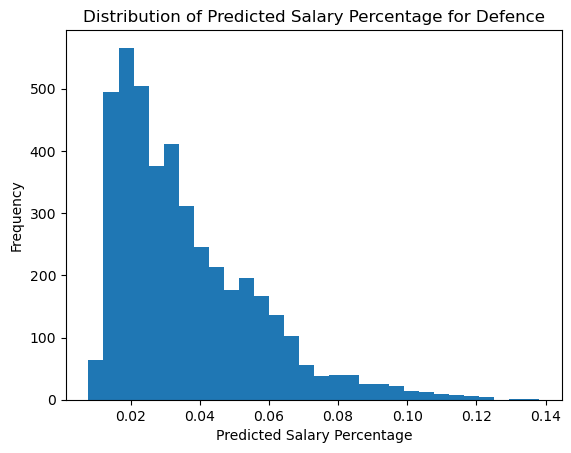

In [15]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Defence')

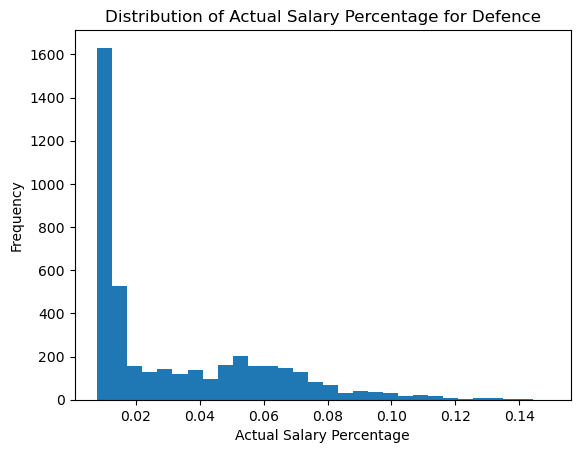

In [16]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Defence')

In [17]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$5,008,071.00","$3,158,071.00",0.059977,3158071.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$3,278,719.00","$1,990,386.00",0.039266,1990386.0
11789,n.j,kevin bahl,2023-24,"$1,050,000.00","$2,761,445.00","$1,711,445.00",0.033071,1711445.0
12043,ari,sean durzi,2023-24,"$1,700,000.00","$3,406,608.00","$1,706,608.00",0.040798,1706608.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,695,116.00","$1,686,783.00",0.032277,1686783.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$2,947,293.00","$1,447,293.00",0.035297,1447293.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,155,995.00","$1,230,995.00",0.025820,1230995.0
11784,mtl,kaiden guhle,2023-24,"$1,283,333.00","$2,489,331.00","$1,205,998.00",0.029812,1205998.0
11660,"ana, tor",ilya lyubushkin,2023-24,"$2,750,000.00","$3,818,105.00","$1,068,105.00",0.045726,1068105.0
11534,phi,cam york,2023-24,"$1,600,000.00","$2,602,221.00","$1,002,221.00",0.031164,1002221.0


In [18]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
12123,l.a,vladislav gavrikov,2023-24,"$5,875,000.00","$5,370,701.00","$-504,299.00",0.064320,-504299.0
11745,n.j,john marino,2023-24,"$4,400,000.00","$3,855,942.00","$-544,058.00",0.046179,-544058.0
11543,bos,charlie mcavoy,2023-24,"$9,500,000.00","$8,911,797.00","$-588,203.00",0.106728,-588203.0
11831,cgy,mackenzie weegar,2023-24,"$6,250,000.00","$5,606,446.00","$-643,554.00",0.067143,-643554.0
11937,"cgy, van",nikita zadorov,2023-24,"$3,750,000.00","$3,081,447.00","$-668,553.00",0.036904,-668553.0
12024,dal,ryan suter,2023-24,"$3,650,000.00","$2,974,558.00","$-675,442.00",0.035623,-675442.0
11873,edm,mattias ekholm,2023-24,"$6,250,000.00","$5,566,582.00","$-683,418.00",0.066666,-683418.0
11509,wpg,brenden dillon,2023-24,"$3,900,000.00","$3,175,056.00","$-724,944.00",0.038025,-724944.0
12015,nsh,ryan mcdonagh,2023-24,"$6,750,000.00","$5,876,802.00","$-873,198.00",0.070381,-873198.0
11768,col,josh manson,2023-24,"$4,500,000.00","$3,622,415.00","$-877,585.00",0.043382,-877585.0


In [19]:
# Show all players who have a positive differential
filtered_data[filtered_data['Differential'] > 0][['TEAM'] + display_features + ['Differential']].head(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$5,008,071.00","$3,158,071.00",0.059977,3158071.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$3,278,719.00","$1,990,386.00",0.039266,1990386.0
11789,n.j,kevin bahl,2023-24,"$1,050,000.00","$2,761,445.00","$1,711,445.00",0.033071,1711445.0
12043,ari,sean durzi,2023-24,"$1,700,000.00","$3,406,608.00","$1,706,608.00",0.040798,1706608.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,695,116.00","$1,686,783.00",0.032277,1686783.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$2,947,293.00","$1,447,293.00",0.035297,1447293.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,155,995.00","$1,230,995.00",0.025820,1230995.0
11784,mtl,kaiden guhle,2023-24,"$1,283,333.00","$2,489,331.00","$1,205,998.00",0.029812,1205998.0
11660,"ana, tor",ilya lyubushkin,2023-24,"$2,750,000.00","$3,818,105.00","$1,068,105.00",0.045726,1068105.0
11534,phi,cam york,2023-24,"$1,600,000.00","$2,602,221.00","$1,002,221.00",0.031164,1002221.0


In [17]:
filtered_data[filtered_data['PLAYER'] == 'quinn hughes'][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,SF/GP,CF/GP,TOI/GP,DEF. ZONE STARTS/GP,OFF. ZONE FACEOFFS/GP,XGA/GP,FF/GP,DEF. ZONE FACEOFFS/GP,SF/60,HITS TAKEN/60,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11983,van,quinn hughes,2023-24,14.0429,29.8429,24.723333,2.4857,10.4571,1.0286,21.0714,5.3429,34.08,3.09,"$7,850,000.00","$7,405,115.00","$-444,885.00",0.088684,-444885.0


In [19]:
predictions = pd.DataFrame(defence[['PLAYER', 'SEASON', 'TOI/GP', 'PRED_SALARY_PERCENTAGE']])

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'defence_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=False)